In [53]:
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sentence_transformers import SentenceTransformer
from scipy.optimize import linear_sum_assignment
from shapely.geometry import LineString

from lonboard._map import Map
from lonboard._layer import PolygonLayer
from lonboard.colormap import (
    apply_continuous_cmap,
)

In [54]:
mn_blocks_gdf = gpd.read_file(
    "../embedding-geodata/mn_spatial_semantic_block_embeddings.geojson"
)
pluto_gdf = gpd.read_file("../nyc_mappluto/MapPLUTO.shp")

In [55]:
n_clusters = 8
run_spatial_clustering = False
run_semantic_clustering = False
run_cluster_rebalancing = False
export_gdf = False
export_webmap_geodata = True

In [56]:
# Rename BCTCB2020 to lowercase for merging
pluto_gdf = pluto_gdf.rename(columns={"BCTCB2020": "bctcb2020"})

# Filter for Manhattan
manhattan_pluto_gdf = pluto_gdf[pluto_gdf["Borough"] == "MN"].copy()

# Reproject only if not already in EPSG:4326
if manhattan_pluto_gdf.crs != "EPSG:4326":
    manhattan_pluto_gdf = manhattan_pluto_gdf.to_crs("EPSG:4326")

In [57]:
# Run k-means clustering for spatial embeddings
if run_spatial_clustering:
    print(f"Running k means on spatial embeddings with {n_clusters} clusters.")

    feature_cols = [
        "BldgArea",
        "NumFloors",
        "UnitsRes",
        "UnitsTotal",
        "LotArea",
        "YearBuilt",
        "ComArea",
        "NumBldgs",
    ]

    # Create embedding as a numpy array
    mn_blocks_gdf["spatial_embedding"] = mn_blocks_gdf[feature_cols].apply(
        lambda row: row.values.astype(float), axis=1
    )

    # Normalize the embeddings
    emb_array = np.vstack(mn_blocks_gdf["spatial_embedding"].values)
    max_vals = emb_array.max(axis=0)
    emb_array_norm = emb_array / max_vals
    mn_blocks_gdf["spatial_embedding"] = list(emb_array_norm)

    emb_array_norm = np.vstack(mn_blocks_gdf["spatial_embedding"].values)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    mn_blocks_gdf["spatial_cluster"] = kmeans.fit_predict(emb_array_norm)

In [58]:
# run k means clustering for semantic embeddings
if run_semantic_clustering:
    print(f"Running k means on semantic embeddings with {n_clusters} clusters.")
    # Get all non-empty semantic embedding strings from the whole file
    semantic_strings = [
        emb
        for emb in mn_blocks_gdf["semantic_embedding"].values
        if isinstance(emb, str) and emb.strip() != ""
    ]

    # Generate sentence transformer embeddings
    model = SentenceTransformer("all-MiniLM-L6-v2")
    semantic_vectors = model.encode(semantic_strings)

    # Run k-means clustering
    kmeans_semantic = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans_semantic.fit_predict(semantic_vectors)

    # Assign clusters back to the DataFrame (only for rows with valid embeddings)
    mn_blocks_gdf.loc[
        mn_blocks_gdf["semantic_embedding"].apply(
            lambda x: isinstance(x, str) and x.strip() != ""
        ),
        "semantic_cluster",
    ] = clusters

In [59]:
# Cluster ids are arbitrary, so atttempt to align spatial and semantic clusters ids

if run_cluster_rebalancing:

    def match_clusters(labels_a, labels_b, n_clusters):
        # Build confusion matrix
        confusion = np.zeros((n_clusters, n_clusters), dtype=int)
        for i in range(len(labels_a)):
            confusion[labels_a[i], labels_b[i]] += 1
        # Hungarian algorithm to maximize overlap
        row_ind, col_ind = linear_sum_assignment(-confusion)
        # Build mapping from old to new labels
        mapping = {old: new for old, new in zip(col_ind, row_ind)}
        # Remap labels_b
        labels_b_remapped = np.array([mapping[label] for label in labels_b])
        return labels_b_remapped

    labels_a = mn_blocks_gdf["spatial_cluster"].astype(int).values
    labels_b = mn_blocks_gdf["semantic_cluster"].astype(int).values
    labels_b_remapped = match_clusters(labels_a, labels_b, n_clusters)
    mn_blocks_gdf["semantic_cluster"] = labels_b_remapped

In [60]:
print(mn_blocks_gdf.columns)
print(mn_blocks_gdf["spatial_cluster"].value_counts().sort_index())
print(mn_blocks_gdf["semantic_cluster"].value_counts().sort_index())

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'BldgArea', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotArea', 'YearBuilt', 'ComArea', 'NumBldgs',
       'spatial_embedding', 'spatial_cluster', 'semantic_embedding',
       'semantic_cluster', 'geometry'],
      dtype='object')
spatial_cluster
0    577
1    882
2    668
3    132
4    215
5    956
6    256
7    244
Name: count, dtype: int64
semantic_cluster
0    374
1    421
2    783
3    212
4    496
5    510
6    642
7    492
Name: count, dtype: int64


In [61]:
# Add field to df for RGBA colors from viridis colormap

spatial_cluster_norm = mn_blocks_gdf["spatial_cluster"] / (n_clusters - 1)
spatial_colors_rgba = [
    cm.viridis(val) if not np.isnan(val) else (0, 0, 0, 1)
    for val in spatial_cluster_norm
]
spatial_colors_rgb = [
    [int(r * 255), int(g * 255), int(b * 255)] for r, g, b, a in spatial_colors_rgba
]
mn_blocks_gdf["spatial_color_rgba"] = spatial_colors_rgba
mn_blocks_gdf["spatial_color"] = spatial_colors_rgb

semantic_cluster_norm = mn_blocks_gdf["semantic_cluster"] / (n_clusters - 1)
semantic_colors_rgba = [
    cm.viridis(val) if not np.isnan(val) else (0, 0, 0, 1)
    for val in semantic_cluster_norm
]
semantic_colors_rgb = [
    [int(r * 255), int(g * 255), int(b * 255)] for r, g, b, a in semantic_colors_rgba
]
mn_blocks_gdf["semantic_color_rgba"] = semantic_colors_rgba
mn_blocks_gdf["semantic_color"] = semantic_colors_rgb

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/3368602641.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  mn_blocks_gdf.plot(
/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/3368602641.py:20: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  mn_blocks_gdf.plot(


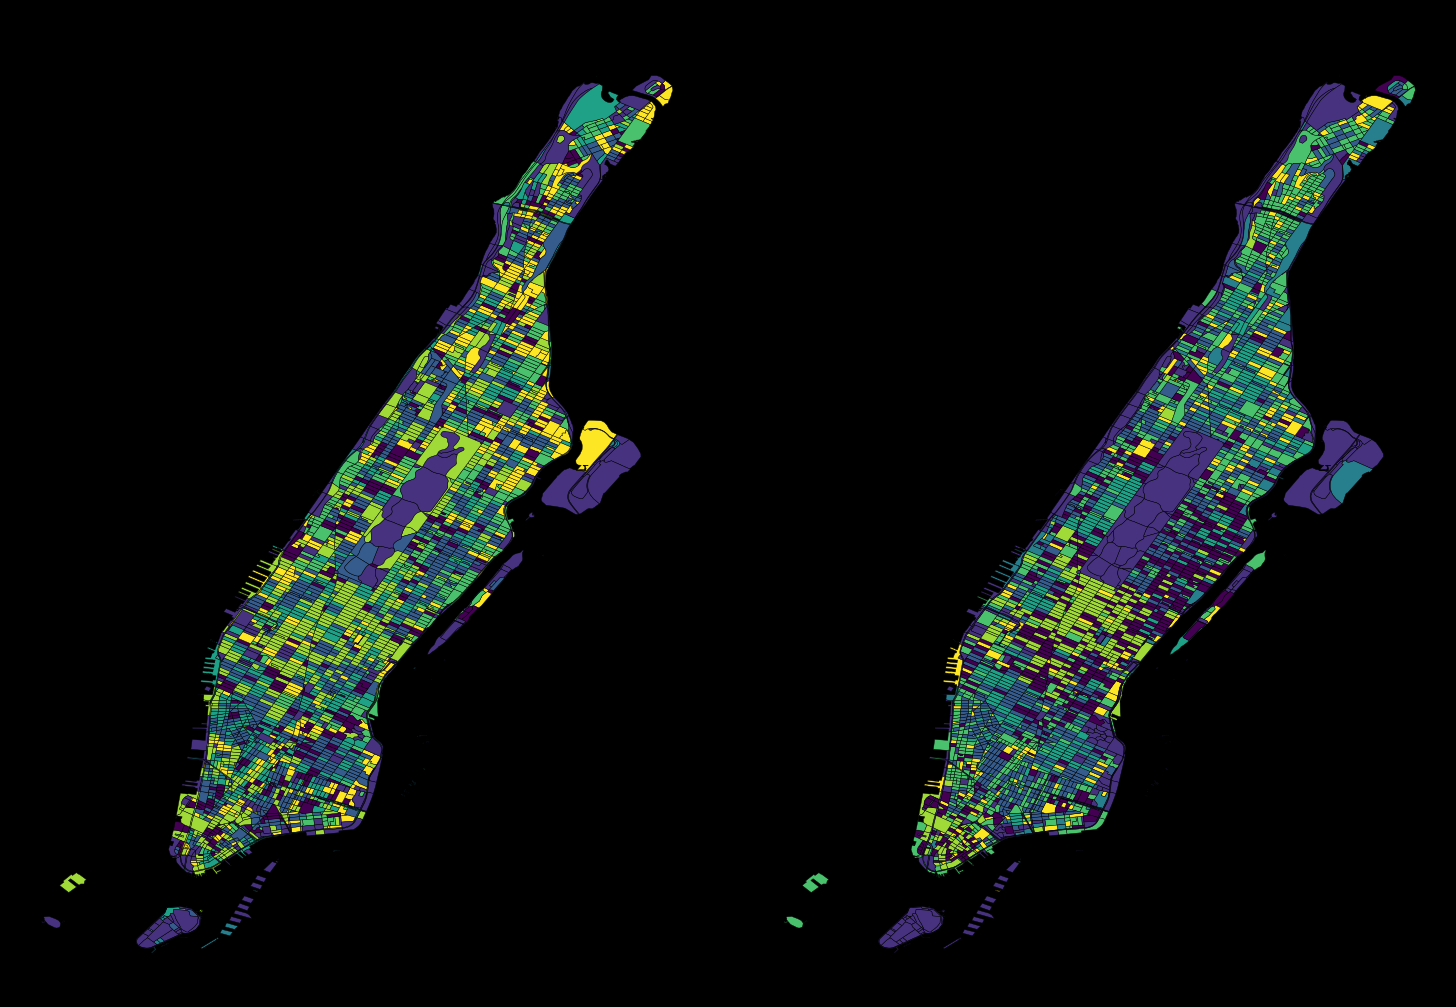

In [76]:
# map semantic clusters and spatial clusters in side by side figures

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Semantic clusters (no legend)
mn_blocks_gdf.plot(
    ax=axes[0],
    column="semantic_cluster",
    # cmap=cm.viridis,
    color=mn_blocks_gdf["semantic_color_rgba"],
    edgecolor="black",
    linewidth=0.3,
    legend=False,
)
axes[0].set_title("Manhattan Blocks Clustered by Semantic Features")
axes[0].set_aspect("equal")
axes[0].axis("off")

# Spatial clusters
mn_blocks_gdf.plot(
    ax=axes[1],
    column="spatial_cluster",
    color=mn_blocks_gdf["spatial_color_rgba"],
    edgecolor="black",
    linewidth=0.3,
    legend=True,
)
axes[1].set_title("Manhattan Blocks Clustered by Spatial Features")
axes[1].set_aspect("equal")
axes[1].axis("off")

fig.patch.set_facecolor("black")


plt.tight_layout()
plt.savefig(
    "../viz/manhattan_clusters.png", facecolor="black", bbox_inches="tight", dpi=300
)
plt.show()

In [63]:
# Select relevant columns from pluto
manhattan_pluto_gdf_simple = manhattan_pluto_gdf[["NumFloors", "geometry", "bctcb2020"]]

# Merge pluto with mn_blocks_gdf to get clusters per bldg
mn_bldg_blocks_gdf = manhattan_pluto_gdf_simple.merge(
    mn_blocks_gdf[
        [
            "bctcb2020",
            "spatial_cluster",
            "semantic_cluster",
            "spatial_color",
            "semantic_color",
        ]
    ],
    on="bctcb2020",
    how="left",
)

# rename num floors
mn_bldg_blocks_gdf = mn_bldg_blocks_gdf.rename(columns={"NumFloors": "num_floors"})

# drop buildings with no cluster (their bctcb2020 did not match anything in mn_blocks_gdf)
mn_bldg_blocks_gdf = mn_bldg_blocks_gdf.dropna(subset=["spatial_cluster"])

In [64]:
print(mn_bldg_blocks_gdf.head())

   num_floors                                           geometry    bctcb2020  \
0         3.5  POLYGON ((-74.01208 40.69205, -74.01215 40.692...  10005000003   
1         1.0  MULTIPOLYGON (((-74.01559 40.70459, -74.01531 ...  10319001003   
2         3.0  POLYGON ((-74.01461 40.7012, -74.01454 40.7011...  10319001006   
3        32.0  POLYGON ((-74.01012 40.7026, -74.0112 40.70243...  10009001014   
4        40.0  POLYGON ((-74.00999 40.70216, -74.01021 40.702...  10009001014   

   spatial_cluster  semantic_cluster   spatial_color  semantic_color  
0              4.0               3.0  [31, 161, 135]  [39, 126, 142]  
1              5.0               1.0  [73, 193, 109]   [70, 49, 126]  
2              5.0               1.0  [73, 193, 109]   [70, 49, 126]  
3              6.0               4.0  [159, 217, 56]  [31, 161, 135]  
4              6.0               4.0  [159, 217, 56]  [31, 161, 135]  


In [65]:
spatial_color_array = np.array(
    mn_bldg_blocks_gdf["spatial_color"].tolist(), dtype=np.uint8
)

layer = PolygonLayer.from_geopandas(
    mn_bldg_blocks_gdf[["spatial_cluster", "geometry"]],
    get_fill_color=spatial_color_array,
    extruded=True,
    get_elevation=mn_bldg_blocks_gdf["num_floors"] * 14,
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x3faface20>
[
  49,
 …

In [66]:
semantic_color_array = np.array(
    mn_bldg_blocks_gdf["semantic_color"].tolist(), dtype=np.uint8
)

layer = PolygonLayer.from_geopandas(
    mn_bldg_blocks_gdf[["semantic_cluster", "geometry"]],
    get_fill_color=semantic_color_array,
    extruded=True,
    get_elevation=mn_bldg_blocks_gdf["num_floors"] * 14,
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x3650120e0>
[
  49,
 …

In [67]:
normalizer = LogNorm(1, mn_blocks_gdf.semantic_cluster.max(), clip=True)
normalized_clusters = normalizer(mn_blocks_gdf.semantic_cluster)

layer = PolygonLayer.from_geopandas(
    mn_blocks_gdf[["semantic_cluster", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_clusters, cmap=cm.viridis),
    extruded=True,
    get_elevation=mn_blocks_gdf["NumFloors"].fillna(1)
    * 14,  # Use block NumFloors or fillna
)
m = Map(
    layer, view_state={"longitude": -73.97, "latitude": 40.73, "zoom": 11, "pitch": 45}
)
m

/Users/elliemadsen/miniforge3/envs/cdp/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x365012620>
[
  0,
  …

In [68]:
if export_gdf:
    # Output all data to CSV
    mn_bldg_blocks_gdf.to_csv(
        "../embedding-geodata/mn_spatial_semantic_block_embeddings.csv", index=False
    )

    # Output all data to GeoJSON
    mn_bldg_blocks_gdf.to_file(
        "../embedding-geodata/mn_spatial_semantic_block_embeddings.geojson",
        driver="GeoJSON",
    )

In [69]:
print(mn_blocks_gdf.columns)

Index(['cb2020', 'borocode', 'boroname', 'ct2020', 'bctcb2020', 'geoid',
       'shape_leng', 'shape_area', 'BldgArea', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotArea', 'YearBuilt', 'ComArea', 'NumBldgs',
       'spatial_embedding', 'spatial_cluster', 'semantic_embedding',
       'semantic_cluster', 'geometry', 'spatial_color_rgba', 'spatial_color',
       'semantic_color_rgba', 'semantic_color'],
      dtype='object')


In [70]:
print(mn_blocks_gdf.crs)
print(mn_blocks_gdf.head().geometry.centroid)

mn_blocks_gdf = mn_blocks_gdf.to_crs(epsg=4326)

print(mn_blocks_gdf.crs)
print(mn_blocks_gdf.head().geometry.centroid)

EPSG:2263
0    POINT (972944.673 193858.649)
1    POINT (971690.778 190614.535)
2     POINT (988073.02 199422.875)
3    POINT (988120.432 199170.585)
4    POINT (988160.842 198788.668)
dtype: geometry
EPSG:4326
0    POINT (-74.04077 40.69877)
1    POINT (-74.04529 40.68986)
2    POINT (-73.98621 40.71405)
3    POINT (-73.98604 40.71335)
4     POINT (-73.98589 40.7123)
dtype: geometry


/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/811773034.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(mn_blocks_gdf.head().geometry.centroid)


In [71]:
print(mn_bldg_blocks_gdf.columns)

Index(['num_floors', 'geometry', 'bctcb2020', 'spatial_cluster',
       'semantic_cluster', 'spatial_color', 'semantic_color'],
      dtype='object')


In [ ]:
# Export cluster data in format with nodes and edges per cluster

if export_webmap_geodata:

    # Block geometry and cluster

    mn_blocks_gdf = mn_blocks_gdf.to_crs(epsg=4326)

    selected_cols = [
        "bctcb2020",
        "geoid",
        "shape_area",
        "NumFloors",
        "spatial_cluster",
        "semantic_cluster",
        "spatial_color",
        "semantic_color",
        "geometry",
    ]
    mn_blocks_gdf_subset = mn_blocks_gdf[selected_cols].copy()
    mn_blocks_gdf_subset = mn_blocks_gdf_subset.rename(
        columns={"NumFloors": "num_floors"}
    )
    mn_blocks_gdf_subset.to_file("../webmap-geodata/blocks.geojson", driver="GeoJSON")

    # Building geometry and cluster

    mn_bldg_blocks_gdf = mn_bldg_blocks_gdf.to_crs(epsg=4326)

    mn_bldg_blocks_gdf.to_file("../webmap-geodata/buildings.geojson", driver="GeoJSON")

    # Node locations as GeoJSON points
    mn_blocks_gdf_subset["centroid"] = mn_blocks_gdf_subset.geometry.centroid
    nodes_gdf = gpd.GeoDataFrame(
        {
            "lat": mn_blocks_gdf_subset.centroid.y,
            "lon": mn_blocks_gdf_subset.centroid.x,
            "spatial_cluster": mn_blocks_gdf_subset["spatial_cluster"],
            "semantic_cluster": mn_blocks_gdf_subset["semantic_cluster"],
            "block_id": mn_blocks_gdf_subset["bctcb2020"],
            "geometry": mn_blocks_gdf_subset.centroid,
            "spatial_color": mn_blocks_gdf_subset["spatial_color"],
            "semantic_color": mn_blocks_gdf_subset["semantic_color"],
        },
        crs=mn_blocks_gdf_subset.crs,
    )
    nodes_gdf.to_file("../webmap-geodata/network_nodes.geojson", driver="GeoJSON")

    # Spatial Network Edges (nearest N neighbors in cluster)

    N = 5  # Number of neighbors

    spatial_edges = []
    for cluster_id in nodes_gdf["spatial_cluster"].unique():
        cluster_nodes = nodes_gdf[
            nodes_gdf["spatial_cluster"] == cluster_id
        ].reset_index(drop=True)
        coords = cluster_nodes[["lat", "lon"]].values
        nbrs = NearestNeighbors(n_neighbors=N + 1).fit(coords)
        distances, indices = nbrs.kneighbors(coords)
        for i, neighbors in enumerate(indices):
            for j in neighbors[1:]:  # skip self
                line = LineString(
                    [
                        (cluster_nodes.iloc[i]["lon"], cluster_nodes.iloc[i]["lat"]),
                        (cluster_nodes.iloc[j]["lon"], cluster_nodes.iloc[j]["lat"]),
                    ]
                )
                spatial_edges.append(
                    {
                        "source_id": cluster_nodes.iloc[i]["block_id"],
                        "target_id": cluster_nodes.iloc[j]["block_id"],
                        "spatial_cluster": cluster_id,
                        "spatial_color": cluster_nodes.iloc[i]["spatial_color"],
                        "geometry": line,
                    }
                )
    spatial_edges_gdf = gpd.GeoDataFrame(spatial_edges, crs=mn_blocks_gdf_subset.crs)
    spatial_edges_gdf.to_file(
        "../webmap-geodata/spatial_network_edges.geojson", driver="GeoJSON"
    )

    # Semantic Network Edges (nearest N neighbors in cluster)

    semantic_edges = []
    for cluster_id in nodes_gdf["semantic_cluster"].unique():
        cluster_nodes = nodes_gdf[
            nodes_gdf["semantic_cluster"] == cluster_id
        ].reset_index(drop=True)
        coords = cluster_nodes[["lat", "lon"]].values
        nbrs = NearestNeighbors(n_neighbors=N + 1).fit(coords)
        distances, indices = nbrs.kneighbors(coords)
        for i, neighbors in enumerate(indices):
            for j in neighbors[1:]:  # skip self
                line = LineString(
                    [
                        (cluster_nodes.iloc[i]["lon"], cluster_nodes.iloc[i]["lat"]),
                        (cluster_nodes.iloc[j]["lon"], cluster_nodes.iloc[j]["lat"]),
                    ]
                )
                semantic_edges.append(
                    {
                        "source_id": cluster_nodes.iloc[i]["block_id"],
                        "target_id": cluster_nodes.iloc[j]["block_id"],
                        "semantic_cluster": cluster_id,
                        "semantic_color": cluster_nodes.iloc[i]["semantic_color"],
                        "geometry": line,
                    }
                )
    semantic_edges_gdf = gpd.GeoDataFrame(semantic_edges, crs=mn_blocks_gdf_subset.crs)
    semantic_edges_gdf.to_file(
        "../webmap-geodata/semantic_network_edges.geojson", driver="GeoJSON"
    )

/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/2466307916.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mn_blocks_gdf_subset["centroid"] = mn_blocks_gdf_subset.geometry.centroid
/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/2466307916.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "lat": mn_blocks_gdf_subset.centroid.y,
/var/folders/q5/x4rs4g890zn1_dtyc2sff4r40000gn/T/ipykernel_9822/2466307916.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "lon": mn_blocks_gdf_subset.centroid.x,
/var/folders/q5/x4rs4g890zn1_dtyc2sff4r